# Initialisation and Dependencies

In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [2]:
%reload_ext autoreload
%autoreload 2

import gc, math, traceback, datetime

import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from datasets import load_from_disk

import whisper
from whisper.tokenizer import get_tokenizer

from utils import audio, gradient, gpu
from utils.attacks import PrepareFront, PrepareAtPosition

# GPU RAM Tracking

In [3]:
device = gpu.get_device()

Device: cuda


# Load Model

In [4]:
try:
    del model
    print("Model deleted!")
except:
    pass

In [5]:
MODEL_NAME = "small.en"

model = whisper.load_model(MODEL_NAME).to(device)
model.eval();

/home/jovyan/libs/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


# Load Data

In [6]:
tedlium_path = "../tedlium"
train_path, validation_path, test_path = f"{tedlium_path}/train_idx.hf", f"{tedlium_path}/validation_idx.hf", f"{tedlium_path}/test.hf"

In [7]:
TRAIN_SELECT = 500
VALID_SELECT = 150
TEST_SELECT = 250

SEED = 1

tedlium_train = load_from_disk(train_path).with_format("torch").shuffle(seed=SEED).select(range(TRAIN_SELECT))
tedlium_validation = load_from_disk(validation_path).with_format("torch").shuffle(seed=SEED).select(range(VALID_SELECT))
tedlium_test = load_from_disk(test_path).with_format("torch").shuffle(seed=SEED).select(range(TEST_SELECT))

Loading dataset from disk:   0%|          | 0/109 [00:00<?, ?it/s]

In [8]:
# def collate(ls):
#     pad_to = max(list(map(lambda x: x["audio"].shape[0], ls)))
#     return torch.cat(list(map(lambda x: F.pad(x["audio"], (0, pad_to - x["audio"].shape[0])).unsqueeze(0).to(torch.bfloat16), ls)), dim=0)

def collate_idx(ls):
    return ls[0]["audio"].unsqueeze(0), ls[0]["idx"].item()

TRAIN_BATCH_SIZE = 1 # highly recommended to be 1
VALID_BATCH_SIZE = 1

train_dataset = DataLoader(tedlium_train, batch_size=TRAIN_BATCH_SIZE, collate_fn=collate_idx)
validation_dataset = DataLoader(tedlium_validation, batch_size=VALID_BATCH_SIZE, collate_fn=collate_idx)
test_dataset = DataLoader(tedlium_test)

# Training Loop

In [9]:
gc.collect()
torch.cuda.empty_cache()
gpu.print_cuda_usage()

0.902857780456543 GB


In [10]:
LR = 1e-3
PATIENCE = 4
MIN_LIMIT = 45
ITER_LIMIT = 30
CLAMP_EP = 0.005
SNIPPET_SIZE = (1, 16_000)
POSITION = 0
PREPARE_METHOD = PrepareAtPosition(SNIPPET_SIZE, POSITION)

writer = None

In [11]:
# tensorboard writer
timestamp = datetime.datetime.now().strftime(f'%Y%m%d-%H%M%S_size_{SNIPPET_SIZE}_{PREPARE_METHOD.name}')
writer = SummaryWriter(log_dir=f"../runs/size_tests/{timestamp}", max_queue=5)

In [12]:
best_snippet, snippets, _, _ = gradient.train(model, train_dataset, validation_dataset, 
                                                            PREPARE_METHOD,
                                                            writer, lr=LR, 
                                                            train_success=None, valid_success=None,
                                                            iter_limit=ITER_LIMIT, mins_limit=MIN_LIMIT, patience=PATIENCE, clamp_epsilon=CLAMP_EP)

/home/jovyan/libs/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Prepare method: prepare_at_position
Snippet initialised to [2.453388958656433e-07, 0.0049994089640676975] of size (1, 16000)
Clamp: 0.005
Time Limit (Mins): 45
Epochs Limit: 30
Tracking training success: False
Tracking valid success: False


Training:   0% 0/1 [01:49<?, ?it/s, Iter 1, Validation Batch 150/150]

Trng Avg Loss: 4.04740571975708 | Valid Avg Loss: 2.308760404586792 | Patience: 4 | LR: [0.001] | Epoch Limit: 29


Training:   0% 0/1 [03:12<?, ?it/s, Iter 2, Validation Batch 150/150]

Trng Avg Loss: 1.7096012830734253 | Valid Avg Loss: 1.3135665655136108 | Patience: 4 | LR: [0.001] | Epoch Limit: 28


Training:   0% 0/1 [04:28<?, ?it/s, Iter 4, Training Batch 2/500]    

Trng Avg Loss: 1.1716806888580322 | Valid Avg Loss: 1.3836030960083008 | Patience: 3 | LR: [0.001] | Epoch Limit: 27


Training:   0% 0/1 [05:42<?, ?it/s, Iter 5, Training Batch 1/500]    

Trng Avg Loss: 1.2638580799102783 | Valid Avg Loss: 2.383894920349121 | Patience: 2 | LR: [0.001] | Epoch Limit: 26


Training:   0% 0/1 [06:58<?, ?it/s, Iter 5, Validation Batch 150/150]

Trng Avg Loss: 1.1409498453140259 | Valid Avg Loss: 1.669167160987854 | Patience: 1 | LR: [0.001] | Epoch Limit: 25


Training:   0% 0/1 [08:18<?, ?it/s, Iter 7, Training Batch 1/500]    

Trng Avg Loss: 0.39465683698654175 | Valid Avg Loss: 0.35254648327827454 | Patience: 4 | LR: [0.0005] | Epoch Limit: 24


Training:   0% 0/1 [09:38<?, ?it/s, Iter 7, Validation Batch 150/150]

Trng Avg Loss: 0.3180703818798065 | Valid Avg Loss: 0.47847676277160645 | Patience: 3 | LR: [0.0005] | Epoch Limit: 23


Training:   0% 0/1 [10:52<?, ?it/s, Iter 9, Training Batch 1/500]    

Trng Avg Loss: 0.38237303495407104 | Valid Avg Loss: 1.0511348247528076 | Patience: 2 | LR: [0.0005] | Epoch Limit: 22


Training:   0% 0/1 [12:11<?, ?it/s, Iter 10, Training Batch 1/500]   

Trng Avg Loss: 0.6026925444602966 | Valid Avg Loss: 1.0680115222930908 | Patience: 1 | LR: [0.0005] | Epoch Limit: 21


Training:   0% 0/1 [13:28<?, ?it/s, Iter 10, Validation Batch 150/150]

Trng Avg Loss: 0.44267356395721436 | Valid Avg Loss: 0.4175202548503876 | Patience: 0 | LR: [0.0005] | Epoch Limit: 20


Training:   0% 0/1 [13:28<?, ?it/s, Patience expired! Terminating...] 

Cleared buffer
Cleared loss
1.822845458984375 GB


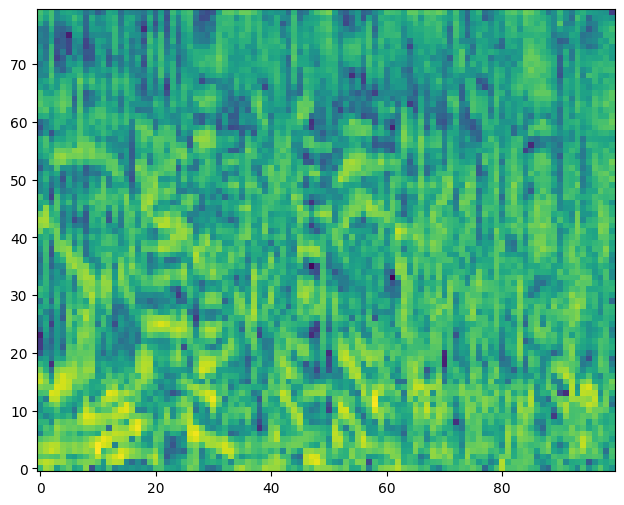

In [13]:
audio.view_mel(best_snippet.detach().to("cpu").squeeze())

# Evaluation

In [14]:
gradient.evaluate(model, best_snippet, PREPARE_METHOD, test_dataset, CLAMP_EP, POSITION) # commented to prevent the runtime from autorunning and crashing the thing

Clamp: 0.005
Prepare Method: prepare_at_position
Snippet Size: (1, 16000)
Position: 0


Inference: 100%|██████████| 250/250 [00:24<00:00, 10.23it/s, Valid Examples: 194 | Empty Sequences: 194 | Total SL = 0]



Total valid examples: 194
Success rate (Empty): 1.0
Success rate (ASL): 0.0 (attacked) out of 122.16494845360825 (original)


In [15]:
random_snippet = torch.rand(SNIPPET_SIZE) * CLAMP_EP
gradient.evaluate(model, random_snippet, PREPARE_METHOD, test_dataset, CLAMP_EP, POSITION) # commented to prevent the runtime from autorunning and crashing the thing

Clamp: 0.005
Prepare Method: prepare_at_position
Snippet Size: (1, 16000)
Position: 0


Inference: 100%|██████████| 250/250 [01:28<00:00,  2.83it/s, Valid Examples: 194 | Empty Sequences: 0 | Total SL = 23833]



Total valid examples: 194
Success rate (Empty): 0.0
Success rate (ASL): 122.85051546391753 (attacked) out of 122.16494845360825 (original)


# Save Tensors

In [16]:
snippets = torch.stack(list(map(lambda x: x.cpu(), snippets)) + [best_snippet.cpu()])
snippets.shape

torch.Size([12, 1, 16000])

In [17]:
# torch.save(snippets.squeeze(), "snippets.pt")

In [18]:
# torch.save(torch.stack(list(map(torch.tensor, train_success.values()))), "train_success.pt")
# torch.save(torch.tensor(list(train_success.keys())), "train_ids.pt")

In [19]:
# torch.save(torch.stack(list(map(torch.tensor, valid_success.values()))), "valid_success.pt")
# torch.save(torch.tensor(list(valid_success.keys())), "valid_ids.pt")

# Save and Hear Snippet

In [20]:
def normalise(random_snippet, ep):
    # we assume torch.rand inits to [0, 1)
    res = random_snippet * ep * 2 - ep
    print(f"Normalised, Min {torch.min(res)}, Max {torch.max(res)}")
    return res

In [21]:
# Save snippet to wav file
# save_audio(snippet, f"./snippets/clamp_{CLAMP_EP}_{PREPARE_METHOD.name}_snippet_only.wav")

In [22]:
# save_audio(PREPARE_METHOD(snippet.to("cpu"), tedlium_test[2]["audio"].unsqueeze(0)), f"./snippets/clamp_{CLAMP_EP}_{PREPARE_METHOD.name}_combined.wav")